Questions:

1. Why bother re-calibration? GDS-CALIB_STRAIN should take care of kappa, etc.

   Because the calibration wasn't working back then. 

2. Why do FFT in each band of 10-seconds?

   Get median manually. Actually this dur=10sec changes the estimated PSD. It changes enough that goes below QN model. I don't like this dependence. Later version has average'median'

3. Concatnate 3-segments will get overlap between them, which is garbage.

   Median number won't see it. The breaks between segments are like glitches

4. Is LLO_O3_CAL_ER from Pcal sweep uncertainty?
   
5. No ΔC^2 term in summation?

   ($(D_r - D_s)/Q \approx 1$ so the total uncertainty is $\sqrt{\delta G^2 + \delta C^2}$ and that's the measured data fro

6. Not re-binned in log-scale. 

Question for Lee:

1. What's the estimated random variable? PSD or ASD. The code does it like ASD but the equation Q = D - (D-M) shouldn't apply here.

2. 1/2 factor from PSD to ASD?

2. What's the CAL ERR?
Confirm with JOe B about the median correction validation period. The pcal dots should be in the uncertainty envelope. 
See the pcal lines and compare them. 

In [1]:
import numpy as np
import scipy as sp
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import pickle
import control as ctr
from scipy import stats
import scipy.constants as scc
from scipy.io import loadmat
import gwinc

In [2]:

dcnt = 8
rate = 16384
data = {}
strain = {}
fulldur = {}
for i in [2,3,4,5,6,7]:
    with open('data'+str(i+1)+'.p','rb') as file:
        data[i+1] = pickle.load(file)
        fulldur[i+1] = len(data[i+1][1])/rate
    print('Reading data' + str(i+1))



Reading data3
Reading data4
Reading data5
Reading data6
Reading data7
Reading data8


In [3]:
# plt.figure(1)
# titles = {}
# titles[0] = 'DCPD A'
# titles[1] = 'DCPD B'
# titles[2] = 'DCPD SUM'
# titles[3] = 'Unknown'
# titles[4] = 'Unknown'
# titles[5] = 'Unknown'
# titles[6] = 'Unknown'
# titles[7] = 'Unknown'
# titles[8] = 'Unknown'
# titles[9] = 'inPower_25'
# titles[10] = 'darm_in'
# titles[11] = 'Unknown'
# titles[12] = 'norm_gain'
# titles[13] = 'trx_norm'
# titles[14] = 'scale'
# titles[15] = 'Unknown'

# for j in range(16):
#     # plt.subplot(np.int64('53'+str(j+1)))
#     plt.subplot(4,4,j+1)
#     plt.plot(data[3][j])
#     plt.xlabel('index'); plt.ylabel('Column ' + str(j)); 
#     # plt.xscale("log")
#     # plt.yscale(yscale)
#     # ax = plt.gca()
#     # ax.yaxis.set_minor_formatter('{x:.1f}')
#     # ax.yaxis.set_major_formatter('{x:.1f}')
#     plt.grid(which='both')
#     # plt.legend()
#     plt.title(titles[j])


# fig = plt.gcf()
# fig.set_size_inches(18, 12)
# # fig.suptitle(title, y=0.93, fontsize=16)
# # plt.savefig('./fig/C/C_' + filename + '.pdf')
# plt.show()

Four major uncertainties:

- Calibration (optical-sensitivity calibration $\delta G$, servo loop calibration $\delta C$)
- Quantum noise models (modelling uncertainty $\delta M_r$)
- Statistical noise (statistical fluctuations due to PSD estimation $\delta D$, not total uncertainty. )
- Non-stationary changes in the classical noise contributions (relative stationarity uncertainty terms $\delta N$. $\delta N_t$ is time-stationarity and $\delta N_m$ is the operating mode stationarity between unsqz and sqz.)

Subtracted QN is

$Q = D_s - (D_r - M_r)$

The uncertainty propagation $\Delta Q = Q\delta Q$ is 

$\Delta Q^2 = \Delta D_s^2 + \Delta D_r^2 + \Delta M_r^2 + \dfrac{Q^2}{G^2}\Delta G^2 + \dfrac{(D_r - D_s)^2}{C^2} \Delta C^2 + (D_r - M_r)^2\left(\dfrac{\Delta N_t^2}{N_t^2} + \dfrac{\Delta N_m^2}{N_m2}\right)$

Writing in relative uncertainty

$\delta Q^2 = \delta G^2 + \dfrac{1}{Q^2} \left[\Delta D_s^2 + \Delta D_r^2 + \Delta M_r^2 + (D_r - D_s)^2 \delta C^2 + (D_r - M_r)^2 (\delta N_t^2 + \delta N_m^2) \right]$

In [3]:
### Calibration
uimreal, uimimag = np.loadtxt('20191107_AUIM.txt',usecols=(1,2),unpack=True)
pumreal, pumimag = np.loadtxt('20191107_APUM.txt',usecols=(1,2),unpack=True)
tstreal, tstimag = np.loadtxt('20191107_ATST.txt',usecols=(1,2),unpack=True)
Dreal, Dimag = np.loadtxt('20191107_D.txt',usecols=(1,2),unpack=True)
Creal, Cimag = np.loadtxt('20191107_C.txt',usecols=(1,2),unpack=True)

uimfd = uimreal + 1j*uimimag
pumfd = pumreal + 1j*pumimag
tstfd = tstreal + 1j*tstimag
D = Dreal + 1j*Dimag
CC = Creal + 1j*Cimag

# Get frequency vector from calibration measurements
fg = np.loadtxt('20191107_AUIM.txt',usecols=(0),unpack=True)

dcpdsum = {}
kappa_tst = {}
kappa_pum = {}
kappa_uim = {}
kappa_C = {}
inPower_25 = {}
darm_in = {}
norm_gain = {}
trx_norm = {}
scale = {}

C = {}
A = {}
G = {}
power_norm = {}

for i in [2,3,4,5,6,7]: 
        dcpdsum[i+1] = data[i+1][2]
        
        # These kappas are around 1% from 1
        kappa_tst[i+1] = np.median(np.loadtxt('newframedata/data2_'+str(i+1)+'.txt'))
        kappa_pum[i+1] = np.median(np.loadtxt('newframedata/data3_'+str(i+1)+'.txt'))
        kappa_uim[i+1] = np.median(np.loadtxt('newframedata/data4_'+str(i+1)+'.txt'))
        kappa_C[i+1] = np.median(np.loadtxt('newframedata/data5_'+str(i+1)+'.txt'))
        
        inPower_25[i+1] = np.median(data[i+1][9])
        darm_in[i+1] = np.median(data[i+1][11])
        norm_gain[i+1] = np.median(data[i+1][12])
        trx_norm[i+1] = np.median(data[i+1][13])
        scale[i+1] = np.median(data[i+1][14])

        # applying kappa corrections correct for this time
        C[i+1] = CC * kappa_C[i+1]
        A[i+1] = tstfd*kappa_tst[i+1] + pumfd*kappa_pum[i+1] + uimfd*kappa_uim[i+1]
        G[i+1] = C[i+1]*A[i+1]*D        
        power_norm[i+1] = scale[i+1]*darm_in[i+1]/(norm_gain[i+1]*np.sqrt(trx_norm[i+1]))

        
# average three segments to one
G[10] = (G[3]+G[5]+G[7])/3
C[10] = (C[3]+C[5]+C[7])/3
fulldur[10] = fulldur[3]+fulldur[5]+fulldur[7]
power_norm[10] = (power_norm[3]+power_norm[5]+power_norm[7])/3

G[11] = (G[4]+G[6]+G[8])/3
C[11] = (C[4]+C[6]+C[8])/3
fulldur[11] = fulldur[4]+fulldur[6]+fulldur[8]
power_norm[11] = (power_norm[4]+power_norm[6]+power_norm[8])/3



In [4]:
# data_10 = {}
# data_11 = {}
# #Combine 3 references as data 10 and 3 sqz as data 11
# # [0] is PDA, [1] is PDB, [2] is SUM
# for m in range(3):
#     data_10[m] = np.concatenate((data[3][m],data[5][m],data[7][m]),axis = 0)
#     data_11[m] = np.concatenate((data[4][m],data[6][m],data[8][m]),axis = 0)

#Combine 3 references as data 10 and 3 sqz as data 11
# [0] is PDA, [1] is PDB, [2] is SUM
m = 2
data_10 = np.concatenate((data[3][m],data[5][m],data[7][m]),axis = 0)
data_11 = np.concatenate((data[4][m],data[6][m],data[8][m]),axis = 0)


In [5]:
# This way to get PSD is deprecated. New scipy.welch supports average='median' option.

# DARM from DCPD, same proved
darm2 = {}




dur = 10
# dur = 20







rate = 16384
segdur = 2  # fft length per segment [s]

band = range(dur*rate) # each FFT is 10-sec long data

# get sample frequency
dcpdSUM = data_11
f,dcpdsum1 = scipy.signal.welch(dcpdSUM[band],rate,window='hann',nperseg=rate*segdur,noverlap=0.5) 


GG = {}
C0 = {}

# for ind in [1,2,3,4,5,6,7,8,10,11]:
for ind in [3,4,5,6,7,8,10,11]:
# for ind in [11]:
    # print('Starting data ' + str(ind))
    
    darm2s = []
    
    if ind <= 8:
        dcpdSUM = data[ind][2]
    elif ind == 10:
        dcpdSUM = data_10
    elif ind == 11:
        dcpdSUM = data_11

    # Get G and C during each data-taking
    GG[ind] = np.interp(f,fg,G[ind])
    C0[ind] = np.interp(f,fg,C[ind]) 

    band = range(dur*rate)
    n = int(fulldur[ind]/dur) #segment no
    
    # print('start')

    for k in range(n):
        dcpdsumraw = dcpdSUM[band]
        f,dcpdsum1 = scipy.signal.welch(dcpdsumraw,rate,window='hann',nperseg=rate*segdur,noverlap=0.5) 
        # f,dcpdsum1 = scipy.signal.welch(dcpdsumraw,rate,window='hann',nperseg=rate*segdur,noverlap=0.5, average='median') 
        darm2_1 = np.sqrt(dcpdsum1)*abs((1+GG[ind])*(power_norm[ind])/(C0[ind]))
        darm2s.append(darm2_1) 
        band = [x+dur*rate for x in band]
        # print('Finished ' + str(k))

    if ind <= 8:
        darm2[ind] = np.median(darm2s,axis=0)[1:]
    elif ind == 10:
        darm2_10 = np.median(darm2s,axis=0)[1:]
    elif ind == 11:
        darm2_11 = np.median(darm2s,axis=0)[1:]
    
    print('Finished data ' + str(ind))

fbin = f[1:]

Finished data 3
Finished data 4
Finished data 5
Finished data 6
Finished data 7
Finished data 8
Finished data 10
Finished data 11


In [7]:
import sys
sys.path.append('../')
import lib_HY

[f0, S0] = lib_HY.psd(data_11, segdur=2, dur=10)
[f1, S1] = lib_HY.psd(data_11, segdur=2, dur=2)
[f2, S2] = lib_HY.psd(data_11, segdur=2, dur=20)
[f3, S3] = lib_HY.psd_mean(data_11, segdur=2, dur=20)

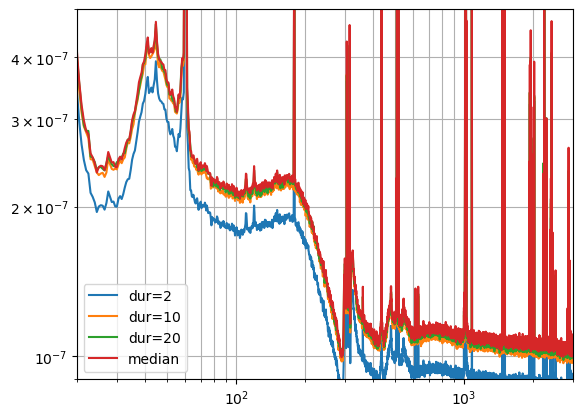

In [8]:
plt.loglog(f1, np.sqrt(S1), label='dur=2')
plt.loglog(f0, np.sqrt(S0), label='dur=10')
plt.loglog(f2, np.sqrt(S2), label='dur=20')
plt.loglog(f3, np.sqrt(S3), label='median')
plt.xlim(20,3000)
plt.ylim(9e-8, 5e-7)
plt.grid(which='both')
plt.legend()
plt.show()


In [9]:
# plt.loglog(fbin, np.sqrt(dcpdsum1[1:]))
# plt.xlim(20,3000)
# plt.show()

In [12]:
L=3995
laserpower = 41*0.9*(1-0.15**2/2)**2
SRMtune = 0.015
PDeff = 0.974*0.985*0.978*0.98*0.9
opticsloss = 40e-6 #match arm power ~80ppm per round 30-50 35before
SRMtrans = 0.33 #0.324


budget = gwinc.load_budget('Aplus')
ifo_nosqz = budget.ifo
ifo_nosqz.Laser.Power = laserpower;
ifo_nosqz.Optics.Loss = opticsloss;# Estimate from post-ETMs swap (based on measurements/calculations)
ifo_nosqz.Optics.coupling = 1;  # To match cavity pole
ifo_nosqz.Optics.BSLoss  = 1.e-3;  #To match PRG 
ifo_nosqz.Optics.PhotoDetectorEfficiency  = PDeff; 
ifo_nosqz.Optics.SRM.Transmittance  = SRMtrans;   # Transmittance of SRM    0.345
ifo_nosqz.Optics.SRM.Tunephase = SRMtune #* np.pi/180;   # SRM tuning
ifo_nosqz.Optics.Quadrature.dc = 90 * np.pi/180;  # demod/detection/homodyne phase pi/2 

ifo_nosqz.Squeezer.Type = 'None'

traces1 = budget.run(freq=fbin, ifo=ifo_nosqz)
qmns_nosqz = L*np.sqrt(traces1.Quantum.psd)

# Get classical noise
techns = np.sqrt((darm2_10)**2-qmns_nosqz**2)

# qmns = {}
# for i in [11]:
#     qmns[i] = np.sqrt(darm2[i]**2-techns**2)
    
qmns_11 = np.sqrt(darm2_11**2-techns**2)

/local/wenxuan.jia/ipykernel_3678177/401639093.py:26: RuntimeWarning: invalid value encountered in sqrt
  techns = np.sqrt((darm2_10)**2-qmns_nosqz**2)
/local/wenxuan.jia/ipykernel_3678177/401639093.py:32: RuntimeWarning: invalid value encountered in sqrt
  qmns_11 = np.sqrt(darm2_11**2-techns**2)


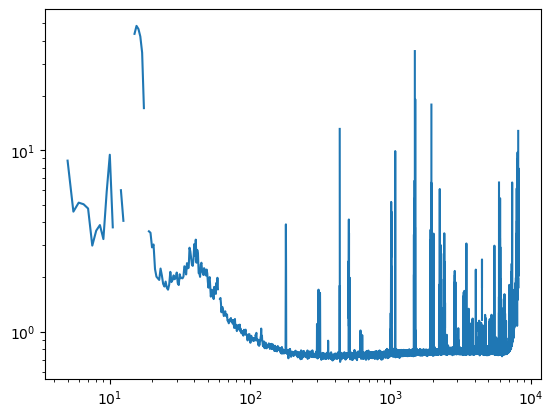

In [17]:
plt.loglog(fbin, darm2_10/qmns_11)

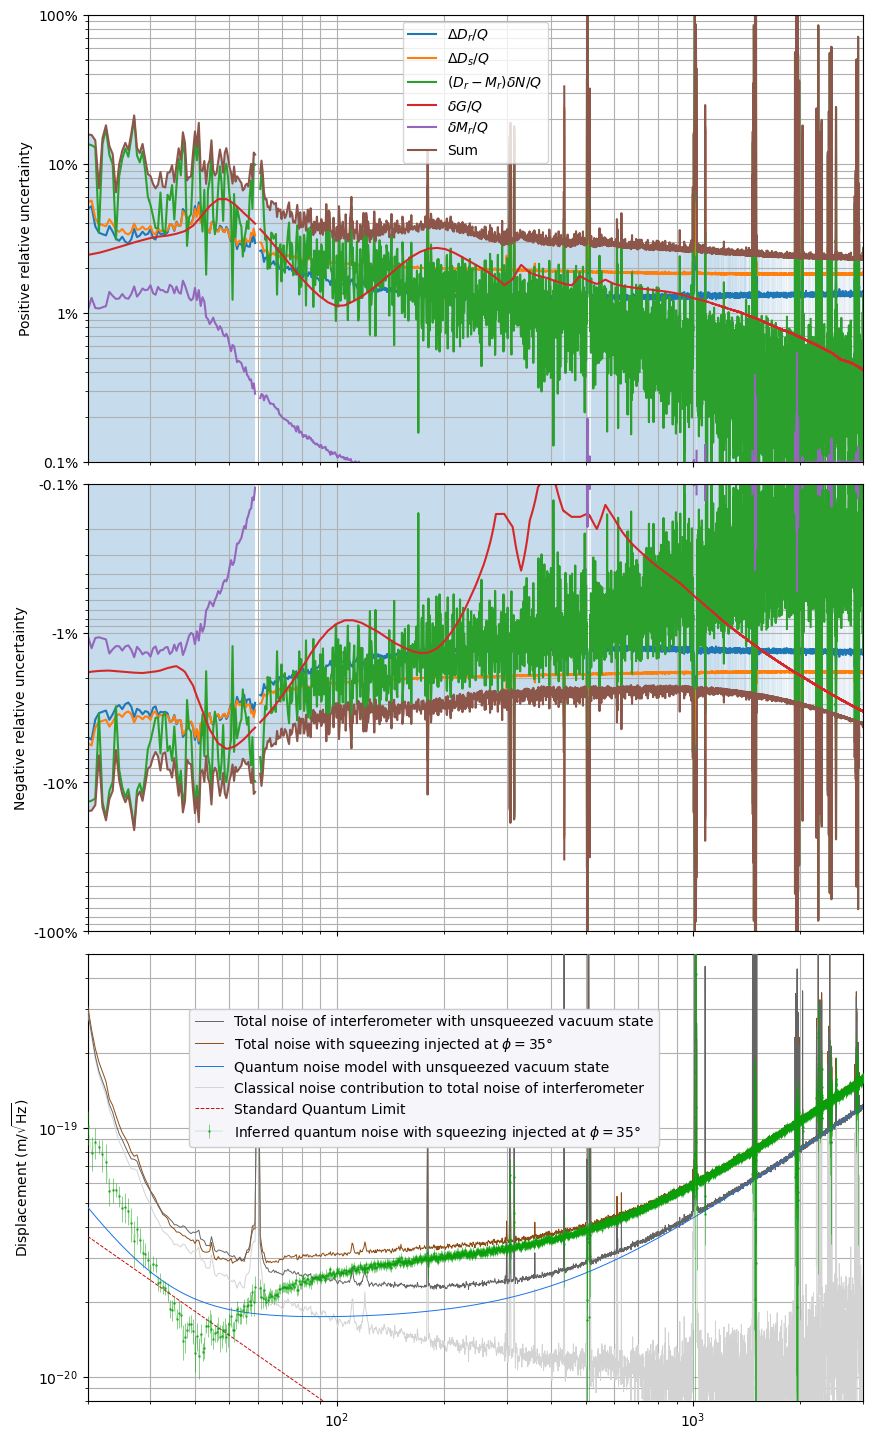

In [19]:
import matplotlib.gridspec as gridspec

# These are N_ij, stationary uncertainty
darm_rel_diff = {}
darm_rel_diff[1] = 2*(darm2[3]**2-darm2[5]**2)/(darm2[5]**2+darm2[3]**2)
darm_rel_diff[3] = 2*(darm2[7]**2-darm2[3]**2)/(darm2[7]**2+darm2[3]**2)
darm_rel_diff[2] = 2*(darm2[7]**2-darm2[5]**2)/(darm2[7]**2+darm2[5]**2)

sqz_rel_diff = {}
sqz_rel_diff[1] = 2*(darm2[6]**2-darm2[4]**2)/(darm2[6]**2+darm2[4]**2)
sqz_rel_diff[3] = 2*(darm2[8]**2-darm2[4]**2)/(darm2[8]**2+darm2[4]**2)
sqz_rel_diff[2] = 2*(darm2[8]**2-darm2[6]**2)/(darm2[8]**2+darm2[6]**2)

N_sum = 1/6*(darm_rel_diff[1]**2+darm_rel_diff[2]**2+darm_rel_diff[3]**2
            +sqz_rel_diff[1]**2+sqz_rel_diff[2]**2+sqz_rel_diff[3]**2)



# Add in calibration error, these are C and G
cal_err_fl= np.loadtxt('LLO_O3_CAL_ER.txt')
fcal = cal_err_fl.T[0]
cal_err_minus = cal_err_fl.T[3]*0.01
cal_err_plus = cal_err_fl.T[4]*0.01
cal_err_m = np.interp(f,fcal,cal_err_minus)[1:]
cal_err_p = np.interp(f,fcal,cal_err_plus)[1:]


# 5% power uncertainty, these are M
ifo_nosqz.Laser.Power = laserpower*1.05;
ifo_nosqz.Optics.PhotoDetectorEfficiency  = PDeff*0.95; 
# ifo_nosqz_p5 = gwinc.precompIFO(fbin, ifo_nosqz)
# qmns_nosqz_p5 = L*np.sqrt(gwinc.noise.quantum.shotrad(fbin, ifo_nosqz_p5))
trace = budget.run(freq=fbin, ifo=ifo_nosqz)
qmns_nosqz_p5 = L*np.sqrt(trace.Quantum.psd)

ifo_nosqz.Laser.Power = laserpower*0.95;
ifo_nosqz.Optics.PhotoDetectorEfficiency  = PDeff*1.05
# ifo_nosqz_m5 = gwinc.precompIFO(fbin, ifo_nosqz)
# qmns_nosqz_m5 = L*np.sqrt(gwinc.noise.quantum.shotrad(fbin, ifo_nosqz_m5))
trace = budget.run(freq=fbin, ifo=ifo_nosqz)
qmns_nosqz_m5 = L*np.sqrt(trace.Quantum.psd)




# 1/deltT*f + plot6 bottom plot 7.2/3  [from eq.12]
err_ref = 1/(fulldur[10]/segdur)*darm2_10**2 # ΔD_r^2
err_sqz = 1/(fulldur[11]/segdur)*darm2_11**2 # ΔD_s^2

# err_ref = 1/(fulldur[10]/segdur)*darm2_10**4 # ΔD_r^2
# err_sqz = 1/(fulldur[11]/segdur)*darm2_11**4 # ΔD_s^2

err_m = (N_sum/3)*techns**2 # (D_r - M_r)^2 δN^2
err_cal_m = (qmns_11*cal_err_m)**2 # ΔG^2 + ΔC^2
err_cal_p = (qmns_11*cal_err_p)**2
err_mdl_m = (qmns_nosqz-qmns_nosqz_m5)**2 # ΔM_r^2
err_mdl_p = (qmns_nosqz_p5-qmns_nosqz)**2

err_qmns_m = np.sqrt(err_ref+err_sqz+err_m+err_cal_m+err_mdl_m)
err_qmns_p = np.sqrt(err_ref+err_sqz+err_m+err_cal_p+err_mdl_p)
err_qmns = [err_qmns_m,err_qmns_p] # ΔQ



fig = plt.figure(figsize=(10, 18));
gs = gridspec.GridSpec(3, 1, hspace=0.05);
ax1 = fig.add_subplot(gs[0]);
ax2 = fig.add_subplot(gs[1], sharex=ax1);
ax3 = fig.add_subplot(gs[2], sharex=ax1);


zeros = qmns_11*0

# plt.subplot(3,1,1)
err_D_r_p = np.sqrt(err_ref)/qmns_11
ax1.loglog(fbin, err_D_r_p, label='$\Delta D_r/Q$')
# ax1.fill_between(fbin, err_D_r_p, zeros, where = err_D_r_p>0, alpha = 0.25, interpolate=True)

err_D_s_p = np.sqrt(err_sqz)/qmns_11
ax1.loglog(fbin, err_D_s_p, label='$\Delta D_s/Q$')
# ax1.fill_between(fbin, err_D_s_p, zeros, where = err_D_s_p>0, alpha = 0.25, interpolate=True)

err_N_p =  np.sqrt(err_m)/qmns_11
ax1.loglog(fbin, err_N_p, label='$(D_r - M_r) \delta N/Q$')

err_G_p =  np.sqrt(err_cal_p)/qmns_11
ax1.loglog(fbin, err_G_p, label='$\delta G/Q$')

err_M_p =  np.sqrt(err_mdl_p)/qmns_11
ax1.loglog(fbin, err_M_p, label='$\delta M_r/Q$')

err_sum_p = err_qmns_p/qmns_11 # err_qmns already sqrt-ed
ax1.loglog(fbin, err_sum_p, label='Sum')
ax1.fill_between(fbin, err_sum_p, zeros, where = err_sum_p>0, alpha = 0.25, interpolate=True)

ax1.grid(which='both')
ax1.set_yticks([0.001, 0.01, 0.1, 1], ['0.1%', '1%', '10%', '100%'])
# ax = ax1.gca()
# ax.axes.xaxis.set_ticklabels([])
ax1.set_xlim(20, 3000); ax1.set_ylim(0.001, 1)
ax1.set_ylabel('Positive relative uncertainty'); 
ax1.legend()



# plt.subplot(3,1,2)
err_D_r_m = np.sqrt(err_ref)/qmns_11
ax2.loglog(fbin, err_D_r_m, label='$\Delta D_r/Q$')
# ax2.fill_between(fbin, err_D_r_m, zeros, where = err_D_r_m>0, alpha = 0.25, interpolate=True)

err_D_s_m = np.sqrt(err_sqz)/qmns_11
ax2.loglog(fbin, err_D_s_m, label='$\Delta D_s/Q$')
# ax2.fill_between(fbin, err_D_s_m, zeros, where = err_D_s_m>0, alpha = 0.25, interpolate=True)

err_N_m =  np.sqrt(err_m)/qmns_11
ax2.loglog(fbin, err_N_m, label='$(D_r - M_r) \delta N/Q$')

err_G_m =  np.sqrt(err_cal_m)/qmns_11
ax2.loglog(fbin, err_G_m, label='$\delta G/Q$')

err_M_m =  np.sqrt(err_mdl_m)/qmns_11
ax2.loglog(fbin, err_M_m, label='$\delta M_r/Q$')

err_sum_m = err_qmns_m/qmns_11 # err_qmns already sqrt-ed
ax2.loglog(fbin, err_sum_m, label='Sum')
ax2.fill_between(fbin, err_sum_m, zeros, where = err_sum_m>0, alpha = 0.25, interpolate=True)

# ax2.xlabel('Frequency [Hz]'); 
ax2.set_ylabel('Negative relative uncertainty'); 
# ax2.xscale("log")
# ax2.yscale(yscale)
# ax = ax2.gca()
# ax.yaxis.set_minor_formatter('{x:.1f}')
# ax.yaxis.set_major_formatter('{x:.1f}')
ax2.grid(which='both')
# ax2.legend()
# ax2.title(titles[j])
ax2.set_yticks([0.001, 0.01, 0.1, 1], ['-0.1%', '-1%', '-10%', '-100%'])
ax2.set_xlim(20, 3000); ax2.set_ylim(0.001, 1)
# plt.gca().invert_yaxis()
ax2.invert_yaxis()


# plt.subplot(3,1,3)
# ax = plt.figure(figsize=(7.2, 4.2),dpi = 300)
ax3.errorbar(fbin,qmns_11,err_qmns, ecolor=[10/255,160/255,10/255], marker='o', markerfacecolor=[10/255,160/255,10/255], alpha=0.8,
             ms=1.75,ls='-',lw=0.15,c=[10/255,160/255,10/255],elinewidth=0.42,capsize=0,mew=0,zorder=20,label='Inferred quantum noise with squeezing injected at $\phi=$35\xb0')
#ax3.title('Spectrum')
ax3.loglog(fbin,darm2_10,c=[100/255,100/255,100/255],label = 'Total noise of interferometer with unsqueezed vacuum state',linewidth = 0.7,zorder=10)
ax3.loglog(fbin,darm2_11,c=[140/255,75/255,20/255],label = 'Total noise with squeezing injected at $\phi=$35\xb0',linewidth = 0.7,zorder=3)
ax3.loglog(fbin,qmns_nosqz,c = [26/255,115/255,232/255],lw = 0.7,label='Quantum noise model with unsqueezed vacuum state',zorder=15)
ax3.loglog(fbin,techns,c = 'lightgray', lw = 0.7,label='Classical noise contribution to total noise of interferometer', zorder = 5) 

SQL = np.sqrt(scc.hbar/(2*10))/(scc.pi*fbin)
ax3.loglog(fbin,SQL,c=[200/255,10/255,10/255],label='Standard Quantum Limit',linestyle='--',linewidth = 0.7, zorder = 5)


ax3.set_ylabel(r'Displacement $\mathrm{(m/\sqrt{Hz})}$')
ax3.legend(bbox_to_anchor=(0.426, 0.492, 0.32, 0.4), 
        facecolor=[246/255,246/255,250/255],framealpha = 1,fancybox = 'True',
          labelspacing= 0.5).set_zorder(50)
ax3.set_xlim(20,3000)
# ax3.xticks([20,50,100,500,1000,3000], ('20', '50','100', '500','1000','3000'))
# ax3.yticks([0.8e-20,1e-20,3e-20,5e-20,1e-19,5e-19], ('0.8','1','3','5','10','50'))
# ax.text(0.115, 0.887,r'$\mathrm{\times10^{-20}}$', fontsize=7)
ax3.set_ylim(8e-21, 5e-19)
# ax3.tick_params(labelsize=7, width=0.5)
# ax3.xscale('log')
ax3.set_yscale('log')

# ax3.grid(True, which='both', axis='both', linestyle='-.',linewidth=0.5,color = [207/255,207/255,207/255])
ax3.grid(which='both')


# fig = plt.gcf()
# fig.set_size_inches(10, 18)
# fig.suptitle(title, y=0.93, fontsize=16)
plt.setp(ax1.get_xticklabels(), visible=False);
plt.setp(ax2.get_xticklabels(), visible=False);
# plt.savefig('./Sup_Fig_1_allerr_dur_10.pdf')
# plt.show()



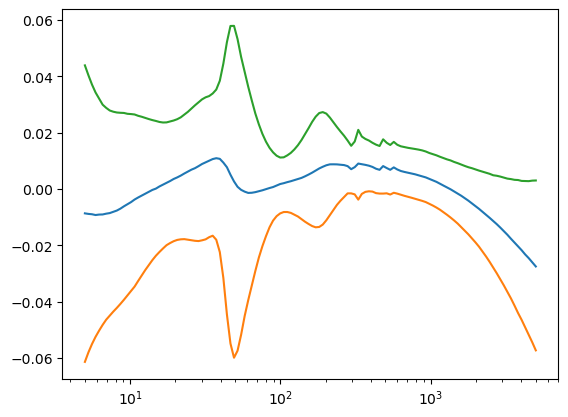

In [12]:
# Add in calibration error
cal_err_fl= np.loadtxt('LLO_O3_CAL_ER.txt')
fcal = cal_err_fl.T[0]
cal = cal_err_fl.T[1]*0.01
cal_err_minus = cal_err_fl.T[3]*0.01
cal_err_plus = cal_err_fl.T[4]*0.01
# cal_err_m = np.interp(f,fcal,cal_err_minus)[1:]
# cal_err_p = np.interp(f,fcal,cal_err_plus)[1:]

plt.semilogx(fcal, cal)
plt.semilogx(fcal, cal_err_minus)
plt.semilogx(fcal, cal_err_plus)
plt.show()

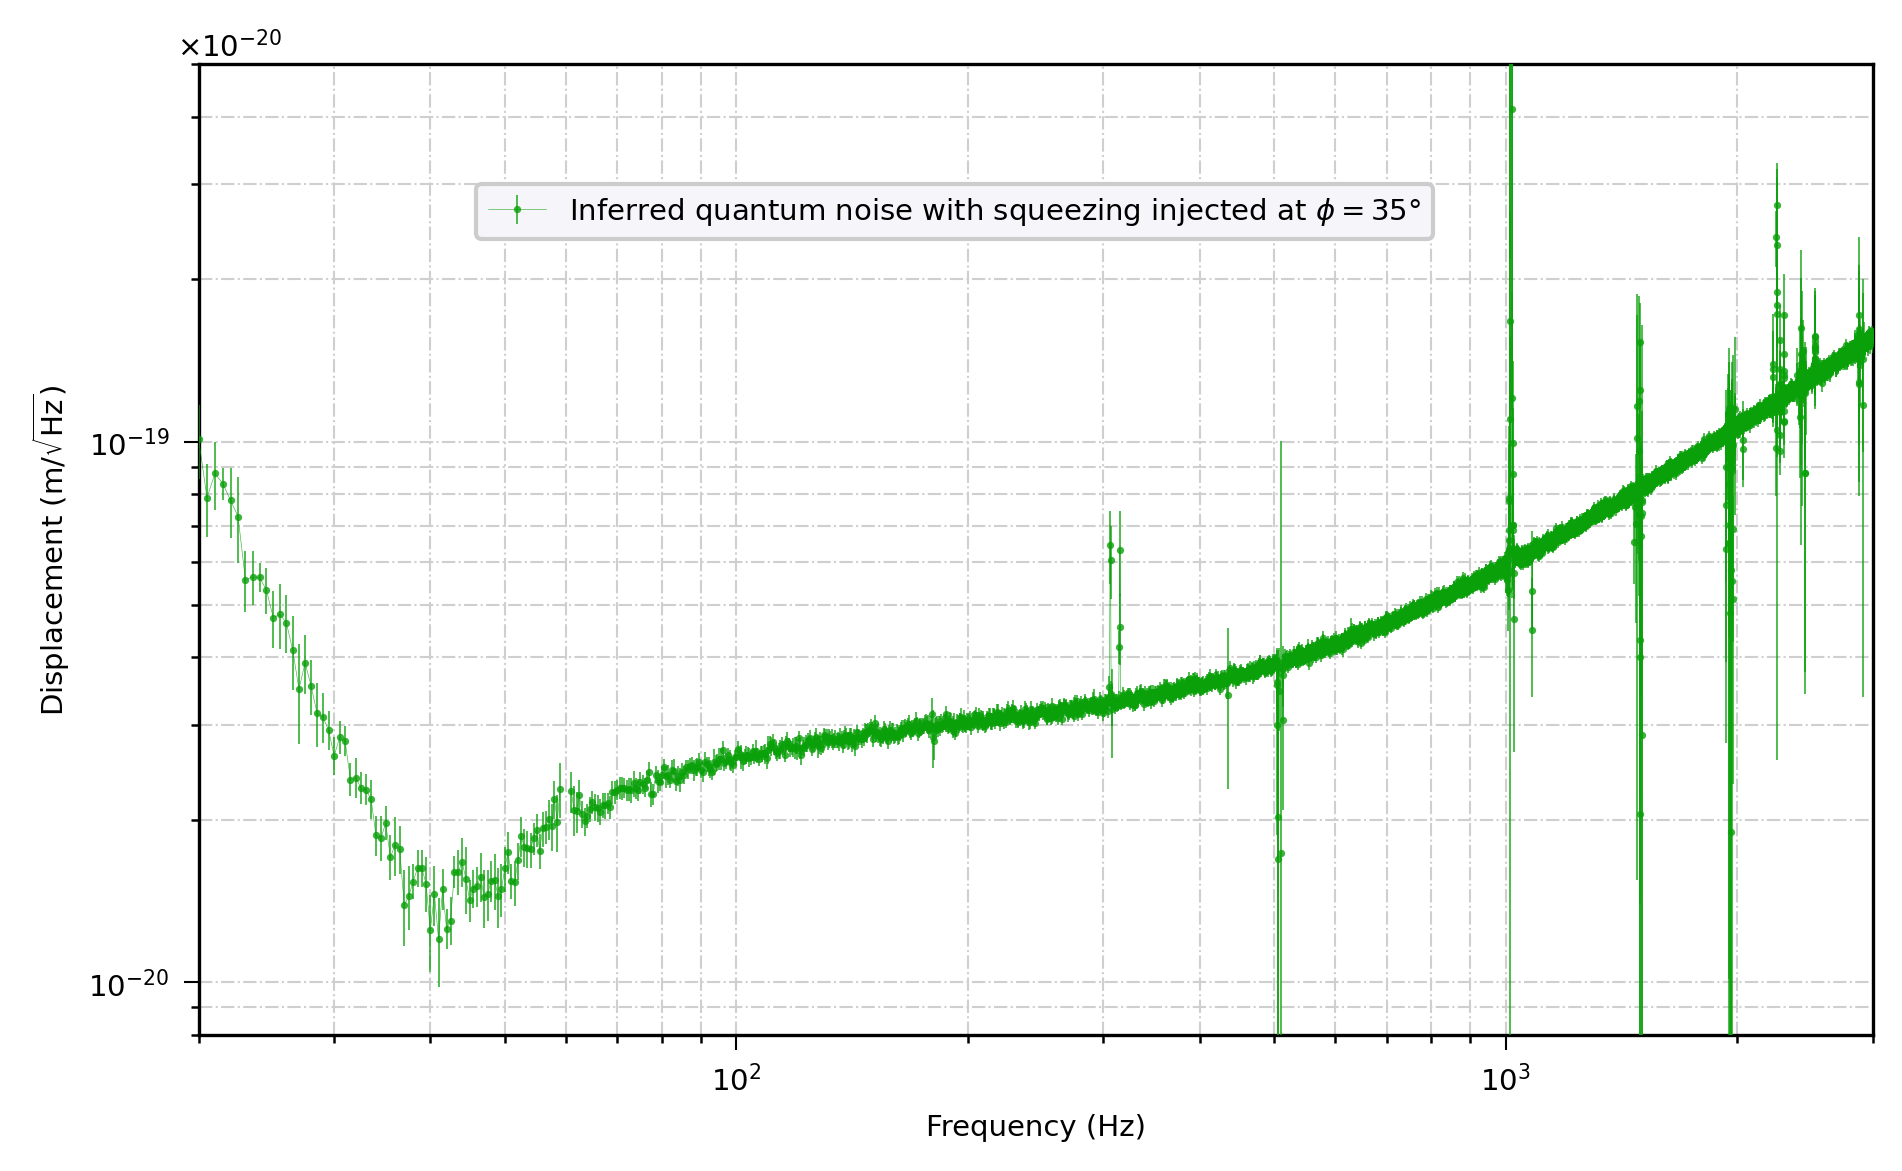

In [13]:
ax = plt.figure(figsize=(7.2, 4.2),dpi = 300)
plt.errorbar(fbin,qmns_11,err_qmns, ecolor=[10/255,160/255,10/255], marker='o', markerfacecolor=[10/255,160/255,10/255], alpha=0.8,
             ms=1.75,ls='-',lw=0.15,c=[10/255,160/255,10/255],elinewidth=0.42,capsize=0,mew=0,zorder=20,label='Inferred quantum noise with squeezing injected at $\phi=$35\xb0')
#plt.title('Spectrum')
plt.xlabel('Frequency (Hz)', fontsize=7)
plt.ylabel(r'Displacement $\mathrm{(m/\sqrt{Hz})}$', fontsize=7)
plt.legend(bbox_to_anchor=(0.426, 0.492, 0.32, 0.4),fontsize=7,
        facecolor=[246/255,246/255,250/255],framealpha = 1,fancybox = 'True',
          labelspacing= 0.5).set_zorder(50)
plt.xlim(20,3000)
plt.xticks([20,50,100,500,1000,3000], ('20', '50','100', '500','1000','3000'))
plt.yticks([0.8e-20,1e-20,3e-20,5e-20,1e-19,5e-19], ('0.8','1','3','5','10','50'))
ax.text(0.115, 0.887,r'$\mathrm{\times10^{-20}}$', fontsize=7)
plt.ylim(8e-21, 5e-19)
plt.tick_params(labelsize=7, width=0.5)
plt.xscale('log')
plt.yscale('log')

plt.grid(True, which='both', axis='both', linestyle='-.',linewidth=0.5,color = [207/255,207/255,207/255])
plt.show()

In [14]:
ax = plt.figure(figsize=(7.2, 4.2),dpi = 300)
plt.errorbar(fbin,qmns_11,err_qmns, ecolor=[10/255,160/255,10/255], marker='o', markerfacecolor=[10/255,160/255,10/255], alpha=0.8,
             ms=1.75,ls='-',lw=0.15,c=[10/255,160/255,10/255],elinewidth=0.42,capsize=0,mew=0,zorder=20,label='Inferred quantum noise with squeezing injected at $\phi=$35\xb0')
#plt.title('Spectrum')
plt.xlabel('Frequency (Hz)', fontsize=7)
plt.ylabel(r'Displacement $\mathrm{(m/\sqrt{Hz})}$', fontsize=7)
plt.legend(bbox_to_anchor=(0.426, 0.492, 0.32, 0.4),fontsize=7,
        facecolor=[246/255,246/255,250/255],framealpha = 1,fancybox = 'True',
          labelspacing= 0.5).set_zorder(50)
plt.xlim(20,3000)
plt.xticks([20,50,100,500,1000,3000], ('20', '50','100', '500','1000','3000'))
plt.yticks([0.8e-20,1e-20,3e-20,5e-20,1e-19,5e-19], ('0.8','1','3','5','10','50'))
ax.text(0.115, 0.887,r'$\mathrm{\times10^{-20}}$', fontsize=7)
plt.ylim(8e-21, 5e-19)
plt.tick_params(labelsize=7, width=0.5)
plt.xscale('log')
plt.yscale('log')

plt.grid(True, which='both', axis='both', linestyle='-.',linewidth=0.5,color = [207/255,207/255,207/255])
plt.show()

NameError: name 'err_qmns' is not defined

<Figure size 2160x1260 with 0 Axes>

In [ ]:
SQL = np.sqrt(8*scipy.constants.hbar/40/(2*np.pi*fbin)**2)

plt.loglog(fbin, qmns_11)
plt.loglog(fbin, SQL)

plt.xlim(20,1000)
plt.ylim(0.9e-20, 10e-20)
plt.grid(True, which='both')
plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


In [21]:
len(qmns_11)

16384

In [25]:
data = np.vstack((fbin, qmns_11)).T

In [29]:
np.savetxt('nature.txt', data)